In [6]:
import jsonlines
import os

In [27]:
file_path = '/media/mlfavorfit/sdb/contolnet_dataset/control_net_train/train.jsonl'

text_dict = {}
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        text_dict[obj["image"]] = obj["text"]

In [30]:
image_dir = "images"
condition_dir = "conditioning_images"
text_dict = text_dict

def preprocess_line(obj):
    dn = os.path.basename(os.path.dirname(obj['fn']))
    fn = dn + "_" + os.path.basename(obj['fn']) + ".jpg"

    image_fn = os.path.join(image_dir, fn)
    condition_fn = os.path.join(condition_dir, fn)
    return {"image":image_fn, 
            "conditioning_images":condition_fn, 
            "obj_colors":obj["obj_colors"], 
            "bg_colors":obj["bg_colors"], 
            "total_colors":obj["total_colors"],
            "text":text_dict[image_fn]}

In [32]:
file_path = '/home/mlfavorfit/lib/favorfit/kjg/color_and_template_recommendation/favorfit_product_color_datas.jsonl'

data_list = []
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        data_list.append(preprocess_line(obj))

In [36]:
file_path = 'output_jsonline_file.jsonl'  # 쓰기용 파일 경로를 적절하게 수정하세요.

with jsonlines.open(file_path, 'w') as writer:
    writer.write_all(data_list)

In [1]:
from diffusion import UNET

unet = UNET(is_lora=True)
my_model = unet.state_dict()

In [2]:
my_model_lora = my_model.copy()
for cur in my_model.keys():
    if "lora" not in cur:
        my_model_lora.pop(cur)

In [20]:
from safetensors.torch import load_file

pre_model = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/FavorfitStyle.safetensors")

In [34]:
lns = {"encoders":"down_blocks", "bottleneck":"mid_block", "decoders":"up_blocks"}
qkv = ["k","q","v","out"]
ud = ["up","down"]
encoder_layer_map = {1:(0,0), 2:(0,1), 4:(1,0), 5:(1,1), 7:(2,0), 8:(2,1)}
decoder_layer_map = {3:(1,0), 4:(1,1), 5:(1,2), 
                     6:(2,0), 7:(2,1), 8:(2,2),
                     9:(3,0), 10:(3,1), 11:(3,2),}

weight_map = []
for ln in lns.keys():
    if ln == "encoders":
        for layer in encoder_layer_map.keys():
            for attn in [1,2]:
                for t in qkv:
                    for d in ud:
                        weight_map.append(
                            (f"{ln}.{layer}.1.attention_{attn}.{t}_lora_{d}.weight",
                                f"{lns[ln]}.{encoder_layer_map[layer][0]}.attentions.{encoder_layer_map[layer][1]}.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                        )
    elif ln == "decoders":
        for layer in decoder_layer_map.keys():
            for attn in [1,2]:
                for t in qkv:
                    for d in ud:
                        weight_map.append(
                            (f"{ln}.{layer}.1.attention_{attn}.{t}_lora_{d}.weight",
                                f"{lns[ln]}.{decoder_layer_map[layer][0]}.attentions.{decoder_layer_map[layer][1]}.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                        )
    else:
        for attn in [1,2]:
            for t in qkv:
                for d in ud:
                    weight_map.append(
                        (f"{ln}.1.attention_{attn}.{t}_lora_{d}.weight",
                            f"{lns[ln]}.attentions.0.transformer_blocks.0.attn{attn}.processor.to_{t}_lora.{d}.weight")
                    )

In [35]:
new_model_weight = {}
for my_key, pre_key in weight_map:
    if my_model_lora[my_key].shape == pre_model[pre_key].shape:
        new_model_weight[my_key] = pre_model[pre_key]
    else:
        print(my_model_lora[my_key].shape, pre_model[pre_key].shape)
        print((my_key, pre_key))

In [39]:
len(new_model_weight) == len(pre_model)

True

In [40]:
from safetensors.torch import save_file

save_file(new_model_weight, "my_own_lora.safetensors")

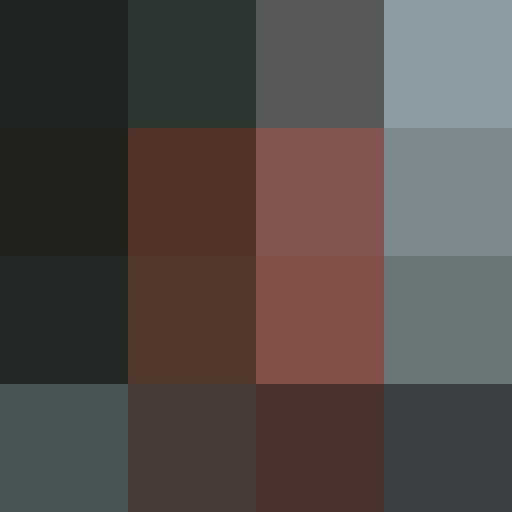

In [5]:
from PIL import Image
import numpy as np

def convert_to_tiles(image_path, tile_size):
    # 이미지 열기
    img = Image.open(image_path).resize([512,512])

    # 이미지 크기 가져오기
    width, height = img.size

    # 8x8 타일 크기 설정
    tile_width, tile_height = tile_size

    # 타일별로 이미지를 자르고 각 타일의 평균 색상 계산
    for y in range(0, height, tile_height):
        for x in range(0, width, tile_width):
            # 타일 자르기
            tile = img.crop((x, y, x + tile_width, y + tile_height))

            # 타일의 평균 색상 계산
            average_color = np.array(tile).mean(axis=(0, 1)).astype(int)

            # 타일에 평균 색상 적용
            tile = Image.fromarray(np.full((tile_height, tile_width, 3), average_color, dtype=np.uint8))

            # 원본 이미지에 타일 적용
            img.paste(tile, (x, y, x + tile_width, y + tile_height))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

# 이미지 경로와 타일 크기 설정
image_path = './images/bottle.jpg'  # 이미지 파일 경로로 바꾸세요
tile_size = (512//4, 512//4)

# 함수 호출
convert_to_tiles(image_path, tile_size)

In [ ]:
from glob import glob
from tqdm import tqdm
import os

tile_size = (512//8, 512//8)

fns = glob("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_base/images/*")
save_dir = "/media/mlfavorfit/sdb/contolnet_dataset/temp"
for fn in tqdm(fns, total=len(fns)):
    img = convert_to_tiles(fn, tile_size)
    img.save(os.path.join(save_dir, os.path.basename(fn)))

In [3]:
save_dir = "/media/mlfavorfit/sdb/contolnet_dataset/temp3"

def combine_images(img_fn, mask_fn, color_fn):
    fn = os.path.basename(img_fn)
    img = np.array(Image.open(img_fn).convert("RGB"))
    mask = np.array(Image.open(mask_fn).convert("RGB"))
    color = np.array(Image.open(color_fn).convert("RGB"))

    result_np = img * (mask/255.0) + color * (1-mask/255.0)
    result_image = Image.fromarray(result_np.astype(np.uint8))
    
    result_image.save(os.path.join(save_dir, fn))

In [6]:
image_fns = glob("/media/mlfavorfit/sdb/product_512_dataset/images/*.jpg")
mask_fns = glob("/media/mlfavorfit/sdb/product_512_dataset/masks/*.jpg")
color_fns = glob("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train_base/conditioning_images_8x8/*.jpg")

for img_fn, mask_fn, color_fn in tqdm(zip(image_fns, mask_fns, color_fns), total=len(image_fns)):
    img = combine_images(img_fn, mask_fn, color_fn)
    break

  0%|          | 0/197967 [00:00<?, ?it/s]


In [7]:
import torch

controlent_dict = torch.load("./checkpoint-115000/controlnet_1.pth")
embedding_dict = torch.load("./checkpoint-115000/embedding_1.pth")
total_dict = {"controlnet":controlent_dict, "embedding": embedding_dict}

torch.save(total_dict, "./controlnet_colot_tile.pth")

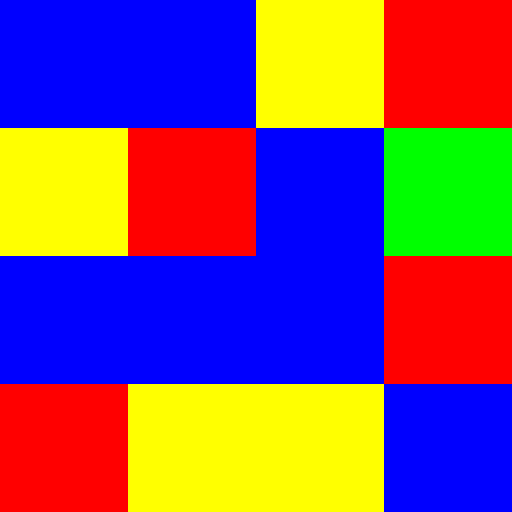

In [9]:
from PIL import Image
import random

def convert_to_random_color_tiles(colors, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            random.shuffle(colors)

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, tuple(colors[0]))

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img


colors = [
    (255, 0, 0),  # 빨간색
    (0, 255, 0),  # 초록색
    (0, 0, 255),  # 파란색
    (255, 255, 0),  # 노란색
]

# 함수 호출
convert_to_random_color_tiles(colors, image_size=[512,512], tile_num_per_row=4)


In [164]:
import torch
import torch.nn as nn

In [165]:
class CModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.C_layer1 = nn.Linear(8,4)
        self.C_layer2 = nn.Linear(4,2)
    
    def forward(self, x):
        x = self.C_layer1(x)
        x = self.C_layer2(x)
        return x
    

class AModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,4)
        self.layer2 = nn.Linear(4,8)
        self.C = CModel()
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.C(x)
        return x
    def get_C(self):
        return self.C

In [166]:
model_a = AModel()
a_state_dict = model_a.state_dict()

In [144]:
class WrappedModel(nn.Module):
    def __init__(self, state_dict) -> None:
        super().__init__()
        for key, value in state_dict.items():
            setattr(self, key, value)

In [145]:
processor = {}

def recursice_named_children(name, cur_module):
    for subname, module in cur_module.named_children():
        recursice_named_children(f"{name}.{subname}",module)
        if "C" in subname:
            processor[f"{name}.{subname}"] = module

In [146]:
cur_modules = model_a.named_children()

In [150]:
cur_model = iter(cur_modules).__next__()
cur_model

('C',
 CModel(
   (C_layer1): Linear(in_features=8, out_features=4, bias=True)
   (C_layer2): Linear(in_features=4, out_features=2, bias=True)
 ))

In [151]:
recursice_named_children(cur_model[0], cur_model[1])

In [152]:
processor

{'C.C_layer1': Linear(in_features=8, out_features=4, bias=True),
 'C.C_layer2': Linear(in_features=4, out_features=2, bias=True)}

In [153]:
wrapped_model = WrappedModel(processor)

In [154]:
wrapped_model

WrappedModel(
  (C.C_layer1): Linear(in_features=8, out_features=4, bias=True)
  (C.C_layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [155]:
from accelerate import Accelerator

accelerator = Accelerator()

In [156]:
import torch
from torch.utils.data import Dataset, DataLoader

class SimpleDataset(Dataset):
    def __init__(self, num_samples):
        samples = []
        for _ in range(num_samples):
            x = torch.rand(1)  # x는 랜덤 값
            y = torch.rand(1)  # y는 랜덤 값
            a = 3 * x + 2 * y
            b = torch.rand(1)  # b는 랜덤 값

            samples.append({'input': torch.cat([x, y]), 'output': torch.cat([a, b])})
        self.samples = samples
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        temp_dict = self.samples[idx]
        return temp_dict["input"], temp_dict["output"]

# 데이터셋 생성
num_samples = 10
simple_dataset = SimpleDataset(num_samples)

# 데이터로더 생성
batch_size = 2
train_dataloader = DataLoader(simple_dataset, batch_size=batch_size, shuffle=True)

In [157]:
optimizer = torch.optim.AdamW(
            wrapped_model.parameters(),
            lr=0.1,
            betas=(0.9, 0.999),
            weight_decay=1e-2,
            eps=1e-08,
        )
from torch.optim.lr_scheduler import LambdaLR
lr_scheduler = LambdaLR(optimizer, lambda _: 1)

In [158]:
wrapped_model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        wrapped_model, optimizer, train_dataloader, lr_scheduler
    )

In [159]:
model_a.to("cuda")

AModel(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (C): CModel(
    (C_layer1): Linear(in_features=8, out_features=4, bias=True)
    (C_layer2): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [162]:
for epoch in range(100):

    for x, y in train_dataloader:
        x = x.to("cuda")
        y = y.to("cuda")
        out = model_a(x)

        loss = torch.nn.functional.mse_loss(out, y, reduction="mean")

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=False)

    print(f"Epoch {epoch}, {loss}")

Epoch 0, 0.004987453576177359
Epoch 1, 0.010965308174490929
Epoch 2, 0.003895475761964917
Epoch 3, 0.022672384977340698
Epoch 4, 0.04985092952847481
Epoch 5, 0.017257962375879288
Epoch 6, 0.0031657549552619457
Epoch 7, 0.008375853300094604
Epoch 8, 0.03736884891986847
Epoch 9, 0.010994495823979378
Epoch 10, 0.0665440559387207
Epoch 11, 0.0022774708922952414
Epoch 12, 0.005960617680102587
Epoch 13, 0.0010876852320507169
Epoch 14, 0.06709764897823334
Epoch 15, 0.013005584478378296
Epoch 16, 0.012147202156484127
Epoch 17, 0.006254617124795914
Epoch 18, 0.03644535690546036
Epoch 19, 0.02989388257265091
Epoch 20, 0.009469026699662209
Epoch 21, 0.00793942529708147
Epoch 22, 0.007803367450833321
Epoch 23, 0.005954444408416748
Epoch 24, 0.021796928718686104
Epoch 25, 0.010215112008154392
Epoch 26, 0.013807850889861584
Epoch 27, 0.010160761885344982
Epoch 28, 0.003038141643628478
Epoch 29, 0.0077806562185287476
Epoch 30, 0.007165942341089249
Epoch 31, 0.061013124883174896
Epoch 32, 0.0341915637

In [161]:
model_a.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.2637, -0.2863],
                      [ 0.4577,  0.5389],
                      [ 0.2914,  0.1599],
                      [-0.5159,  0.3440]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.4801, -0.2358,  0.0052,  0.0658], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.4251,  0.2755,  0.2153, -0.4284],
                      [ 0.2034, -0.4190, -0.4411, -0.1232],
                      [ 0.0289,  0.2993,  0.2970,  0.1596],
                      [ 0.2103, -0.3195,  0.2618,  0.0103],
                      [-0.3904, -0.0397, -0.4616,  0.1199],
                      [ 0.1592,  0.3799, -0.3946, -0.1098],
                      [ 0.2867, -0.2817,  0.2606,  0.3815],
                      [-0.0480,  0.0790, -0.3579, -0.0761]], device='cuda:0')),
             ('layer2.bias',
              tensor([ 0.4700,  0.0951,  0.1737,  0.4081, -0.3703, -0.4907, -0.2209, -0.2582],
                   

In [163]:
model_a.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.2637, -0.2863],
                      [ 0.4577,  0.5389],
                      [ 0.2914,  0.1599],
                      [-0.5159,  0.3440]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.4801, -0.2358,  0.0052,  0.0658], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.4251,  0.2755,  0.2153, -0.4284],
                      [ 0.2034, -0.4190, -0.4411, -0.1232],
                      [ 0.0289,  0.2993,  0.2970,  0.1596],
                      [ 0.2103, -0.3195,  0.2618,  0.0103],
                      [-0.3904, -0.0397, -0.4616,  0.1199],
                      [ 0.1592,  0.3799, -0.3946, -0.1098],
                      [ 0.2867, -0.2817,  0.2606,  0.3815],
                      [-0.0480,  0.0790, -0.3579, -0.0761]], device='cuda:0')),
             ('layer2.bias',
              tensor([ 0.4700,  0.0951,  0.1737,  0.4081, -0.3703, -0.4907, -0.2209, -0.2582],
                   

In [59]:
accelerator.unwrap_model(wrapped_model)

WrappedModel(
  (layers): ModuleList(
    (0): CModel(
      (layer1): Linear(in_features=4, out_features=3, bias=True)
      (layer2): Linear(in_features=3, out_features=2, bias=True)
    )
  )
)

In [60]:
wrapped_model.state_dict()

OrderedDict([('layers.0.layer1.weight',
              tensor([[-0.9413,  1.8445,  0.1948,  0.1523],
                      [ 1.8247, -4.1675,  0.2298,  0.1094],
                      [-1.1304,  0.8007,  0.3672, -0.0239]], device='cuda:0')),
             ('layers.0.layer1.bias',
              tensor([-0.2499,  0.4548, -0.5478], device='cuda:0')),
             ('layers.0.layer2.weight',
              tensor([[ 0.8566, -2.6253,  0.3337],
                      [-0.2639,  0.2939, -0.2823]], device='cuda:0')),
             ('layers.0.layer2.bias',
              tensor([0.2533, 0.8179], device='cuda:0'))])

In [125]:
from model_loader import load_diffusion_model

kwargs = {"is_lora":True, "lora_scale":1.0}
models = load_diffusion_model(**kwargs)

In [127]:
module_list = models['diffusion'].named_children()

In [132]:
cur_module = iter(module_list).__next__()

In [138]:
processor = {}

def recursice_named_children(name, cur_module):
    for subname, module in cur_module.named_children():
        recursice_named_children(f"{name}.{subname}",module)
        if "lora" in subname:
            processor[f"{name}.{subname}"] = module

In [140]:
recursice_named_children(cur_module[0], cur_module[1])

In [143]:
processor

{'unet.encoders.1.1.attention_1.k_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.k_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.q_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.q_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.v_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.v_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_1.out_lora_down': Linear(in_features=320, out_features=4, bias=False),
 'unet.encoders.1.1.attention_1.out_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.1.1.attention_2.k_lora_down': Linear(in_features=768, out_features=4, bias=False),
 'unet.encoders.1.1.attention_2.k_lora_up': Linear(in_features=4, out_features=320, bias=False),
 'unet.encoders.